In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras 

## Import Dataset

In [2]:
builder = tfds.builder('rock_paper_scissors')
info = builder.info

info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_path='/Users/ezgisubasi/tensorflow_datasets/rock_paper_scissors/3.0.0',
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
)

## Prepare Rock, Paper, Scissors Data

In [3]:
ds_train = tfds.load(name='rock_paper_scissors', split='train')
ds_test = tfds.load(name='rock_paper_scissors', split='test')

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


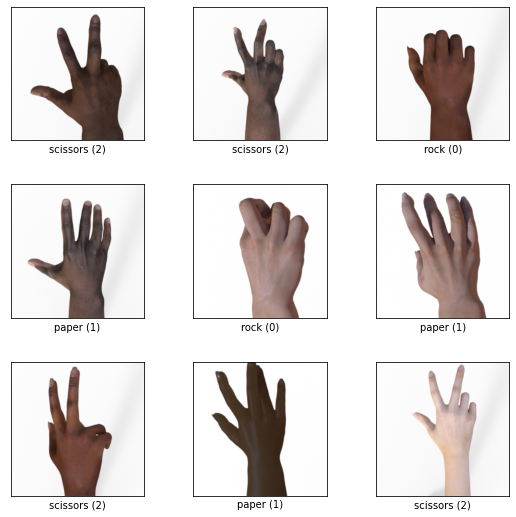

In [4]:
fig = tfds.show_examples(info, ds_train)

In [12]:
# In this part we loaded everything into the numpy

# with numpy()[:, :, 0] we just take red color channel
train_images = np.array([example['image'].numpy()[:,:,0] for example in ds_train])
train_labels = np.array([example['label'].numpy() for example in ds_train])

test_images = np.array([example['image'].numpy()[:,:,0] for example in ds_test])
test_labels = np.array([example['label'].numpy() for example in ds_test])

In [14]:
# 2520 images with the shape of 300, 300, 3
# 3: color channels RGB
train_images.shape

(2520, 300, 300)

In [18]:
# 1 for color channel
train_images = train_images.reshape(2520, 300, 300, 1)
test_images = test_images.reshape(372, 300, 300, 1)

train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# Scaling every value between 0 and 1
train_images /= 255
test_images /= 255

## Train a Basic Network

In [23]:
# Flatten: Transform 300 by 300 image into single column
model = keras.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

In [24]:
model.fit(train_images, train_labels, epochs=5, batch_size=32)

Epoch 1/5
79/79 [==============================] - 14s 164ms/step - loss: 1.0640 - accuracy: 0.4333
Epoch 2/5
79/79 [==============================] - 12s 154ms/step - loss: 0.8402 - accuracy: 0.6258
Epoch 3/5
79/79 [==============================] - 12s 150ms/step - loss: 0.5972 - accuracy: 0.7607
Epoch 4/5
79/79 [==============================] - 12s 152ms/step - loss: 0.4099 - accuracy: 0.8655
Epoch 5/5
79/79 [==============================] - 12s 151ms/step - loss: 0.3464 - accuracy: 0.8829


In [28]:
# Shows how well our model generalizes to unseen data
# %50 of the test is true
model.evaluate(test_images, test_labels)

12/12 [==============================] - 0s 24ms/step - loss: 1.1068 - accuracy: 0.4919


[1.1067955493927002, 0.49193549156188965]

## CNN

In [29]:
# filters (64): how many different smaller grids we're gonna pass on top of our image
# kernel size (3): size of smaller grid, sliding window 3 by 3

model = keras.Sequential([
    keras.layers.Conv2D(64, 3, activation='relu', input_shape=(300,300,1)),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(3, activation='softmax')
])

In [30]:
model.compile(optimizer='adam',
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5, batch_size=32)

Epoch 1/5
79/79 [==============================] - 290s 4s/step - loss: 1.1154 - accuracy: 0.3290
Epoch 2/5
79/79 [==============================] - 280s 4s/step - loss: 1.0987 - accuracy: 0.3198
Epoch 3/5
79/79 [==============================] - 297s 4s/step - loss: 1.0987 - accuracy: 0.3313
Epoch 4/5
79/79 [==============================] - 315s 4s/step - loss: 1.0987 - accuracy: 0.3333
Epoch 5/5
79/79 [==============================] - 319s 4s/step - loss: 1.0987 - accuracy: 0.3270


## Improved Convolutional Network

* Reduced the size of image
* AveragePooling2D: Instead of moving the box entirely over, it moves the box three, each pixel counted twice
* MaxPool2D: Similar w/ average pool but now it's gonna pass over the output with 2 by 2 grids and takes the max pixel in 2 by 2 grids.
* Dropout: After it is done w/ max pool, it basically cut out %50 of the connections therefore epochs will be more effective because this things dropout randomly 
* keras.layers.Dense(128, activation='relu'): with this we are hoping that maybe this layer can capture some higher-layer information

In [56]:
model = keras.Sequential([
    keras.layers.AveragePooling2D(6, 3, input_shape=(300,300,1)),
    keras.layers.Conv2D(64, 3, activation='relu'),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(3, activation='softmax')  
])

In [43]:
model.compile(optimizer='adam',
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5, batch_size=32)

Epoch 1/5
79/79 [==============================] - 37s 465ms/step - loss: 1.0998 - accuracy: 0.3127
Epoch 2/5
79/79 [==============================] - 38s 484ms/step - loss: 1.0987 - accuracy: 0.3190
Epoch 3/5
79/79 [==============================] - 36s 451ms/step - loss: 1.0987 - accuracy: 0.3095
Epoch 4/5
79/79 [==============================] - 31s 393ms/step - loss: 1.0988 - accuracy: 0.3282
Epoch 5/5
79/79 [==============================] - 31s 395ms/step - loss: 1.0987 - accuracy: 0.3147


In [44]:
model.evaluate(test_images, test_labels)

12/12 [==============================] - 2s 118ms/step - loss: 1.0986 - accuracy: 0.3333


[1.0986157655715942, 0.3333333432674408]

## Hyperparameter Tunning (Keras Tuner)

In [47]:
# pip install -U keras-tuner

In [63]:
from tensorflow.keras import layers
from keras_tuner import RandomSearch

# Test the numbers 32 to 512
def build_model(hp):
    model = keras.Sequential()
    
    model.add(keras.layers.AveragePooling2D(6, 3, input_shape=(300,300,1)))
        
    for i in range(hp.Int('Conv Layers', min_value=0, max_value=3)):
        model.add(keras.layers.Conv2D(hp.Choice(f'layer_{i}_filters',[16, 32, 64]), 3, activation='relu')) 
        
    # Original: model.add(keras.layers.Conv2D(64, 3, activation='relu'))
    # Original: model.add(keras.layers.Conv2D(32, 3, activation='relu'))
    
    model.add(keras.layers.MaxPool2D(2, 2))
    model.add(keras.layers.Dropout(0.5))    
    model.add(keras.layers.Flatten())

    # We're gonna tune this layer
    # Original: model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(hp.Choice('Dense layer',[64, 128, 256, 512, 1024]), activation='relu'))
    
    model.add(keras.layers.Dense(3, activation='softmax'))
    
    model.compile(optimizer='adam',
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])
    
    
    return model

In [ ]:
 tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    # Runs random combinations of trials
    max_trials=32, 
    # executions_per_trial=3,
    # directory='my_dir',
    # project_name='helloworld'
)

tuner.search(train_images, train_labels, validation_data=(test_images, test_labels), epochs=10, batch_size=32)

In [ ]:
best_model = tuner.get_best_model()[0]

In [ ]:
best_model.evaluate(test_images, test_labels)

In [ ]:
best_model.summary()

In [ ]:
tuner.results_summary()